**k-NN Classifier Model**


                   KNN MODEL PERFORMANCE                    

Model Accuracy: 0.8474

Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       1.00      0.84      0.91       972
      Stroke       0.23      0.92      0.37        50

    accuracy                           0.85      1022
   macro avg       0.61      0.88      0.64      1022
weighted avg       0.96      0.85      0.89      1022


Evaluation Summary:
ROC AUC Score: 0.9561
Average Precision Score: 0.6635
Sensitivity (Recall): 0.9200
Specificity: 0.8436

Performance visualization saved to:
   /stroke-prediction-project/reports/knn_performance_overview.png

Sensitivity and Specificity visualization saved to:
   /stroke-prediction-project/reports/knn_sensitivity_specificity.png


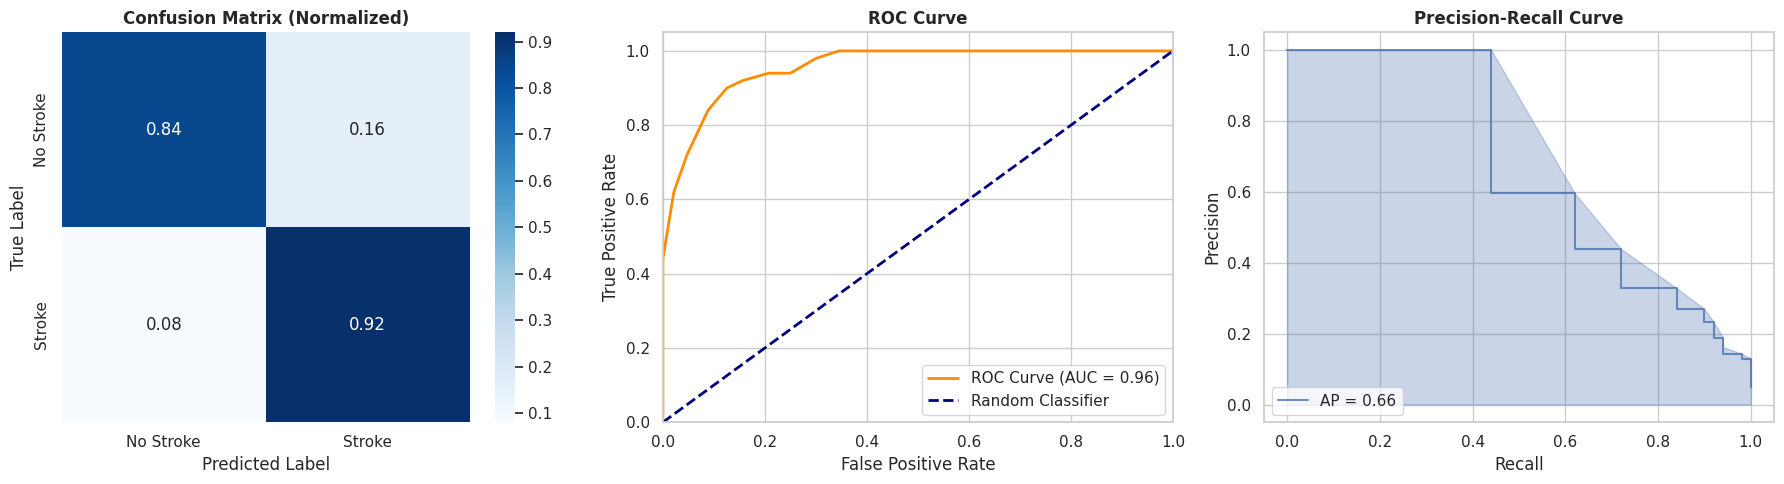

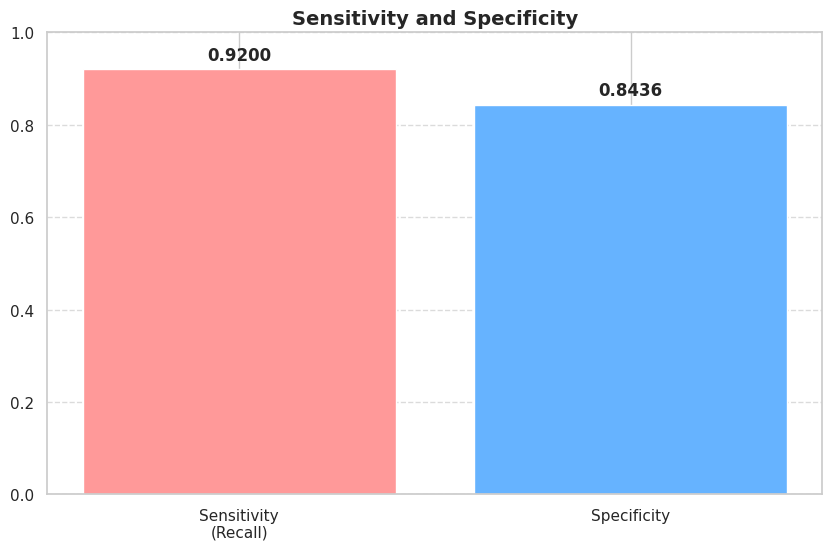

In [11]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
import os

sns.set_theme(style="whitegrid")

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'cleaned_dataset.csv')
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'knn_model.pkl')
REPORT_DIR = os.path.join(BASE_DIR, 'stroke-prediction-project', 'reports')
os.makedirs(REPORT_DIR, exist_ok=True)

def print_header(text):
    print("\n" + "=" * 60)
    print(text.center(60))
    print("=" * 60)

df = pd.read_csv(DATA_PATH)
X = df.drop(columns=['stroke'])
y = df['stroke']

# Applying the train-test split with 20% of the overall dataset as the test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Loading the trained model:
knn_model = joblib.load(MODEL_PATH)

# Storing the predictions:
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

print_header("KNN MODEL PERFORMANCE")

# Accuracy and Classification Report:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nDetailed Classification Report:")
class_report = classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"])
print(class_report)

# Calculating the sensitivity (recall) and specificity:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)

# Printing the Evaluation Summary:
print("\nEvaluation Summary:")
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

plt.figure(figsize=(18, 5))

# 1. Confusion Matrix (Normalized):
plt.subplot(131)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. ROC Curve:
plt.subplot(132)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve:
plt.subplot(133)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.8, where='post', label=f'AP = {avg_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower left")

plt.tight_layout()
report_path = os.path.join(REPORT_DIR, 'knn_performance_overview.png')
plt.savefig(report_path, dpi=300)

print(f"\nPerformance visualization saved to:\n   {report_path}")

plt.figure(figsize=(10, 6))
metrics = ['Sensitivity\n(Recall)', 'Specificity']
values = [sensitivity, specificity]
colors = ['#ff9999', '#66b3ff']

plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.0)
plt.title('Sensitivity and Specificity', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

sens_spec_path = os.path.join(REPORT_DIR, 'knn_sensitivity_specificity.png')
plt.savefig(sens_spec_path, dpi=300)

print(f"\nSensitivity and Specificity visualization saved to:\n   {sens_spec_path}")

INFO: Best Parameters: {'feature_selection__k': 8, 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
INFO: Best ROC AUC Score: 0.7797

**Bayesian Learning (Gaussian Naive Bayes) Model**


           GAUSSIAN NAIVE BAYES MODEL PERFORMANCE           

Model Accuracy: 0.7671

Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.99      0.77      0.86       972
      Stroke       0.15      0.78      0.25        50

    accuracy                           0.77      1022
   macro avg       0.57      0.77      0.55      1022
weighted avg       0.94      0.77      0.83      1022


Evaluation Summary:
ROC AUC Score: 0.8205
Average Precision Score: 0.1973
Sensitivity (Recall): 0.7800
Specificity: 0.7665

Performance visualization saved to:
   /stroke-prediction-project/reports/gnb_performance_overview.png

Sensitivity and Specificity visualization saved to:
   /stroke-prediction-project/reports/gnb_sensitivity_specificity.png


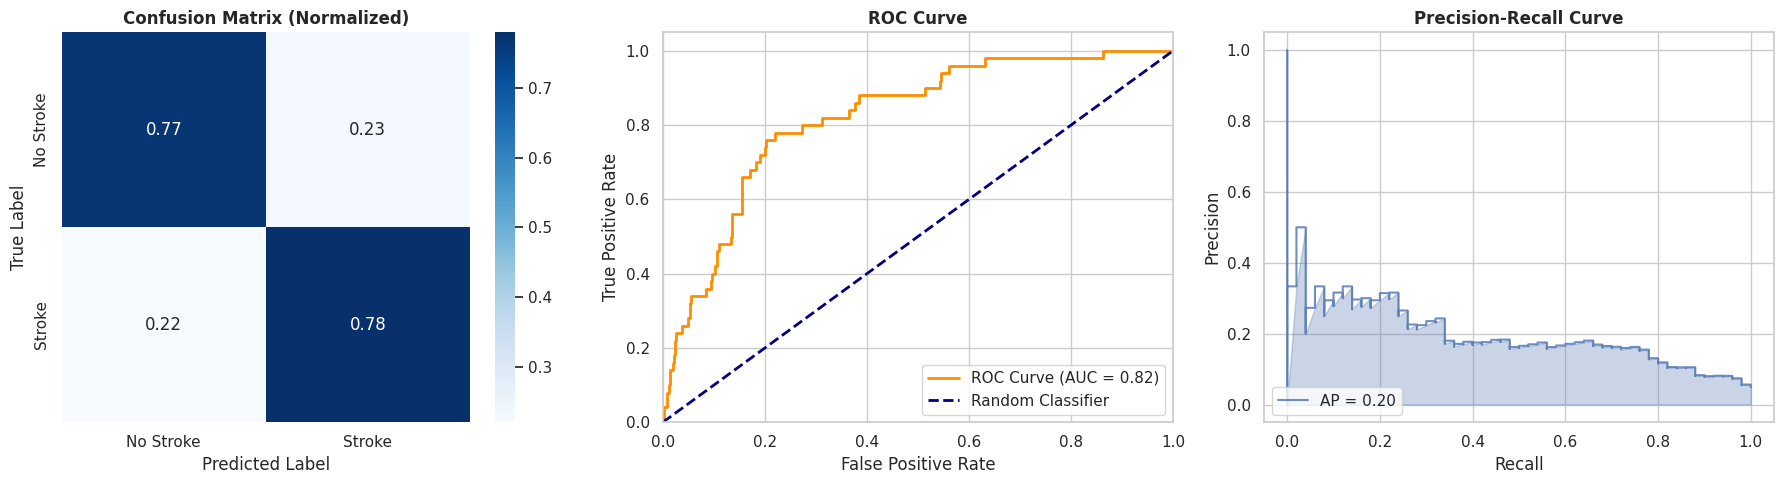

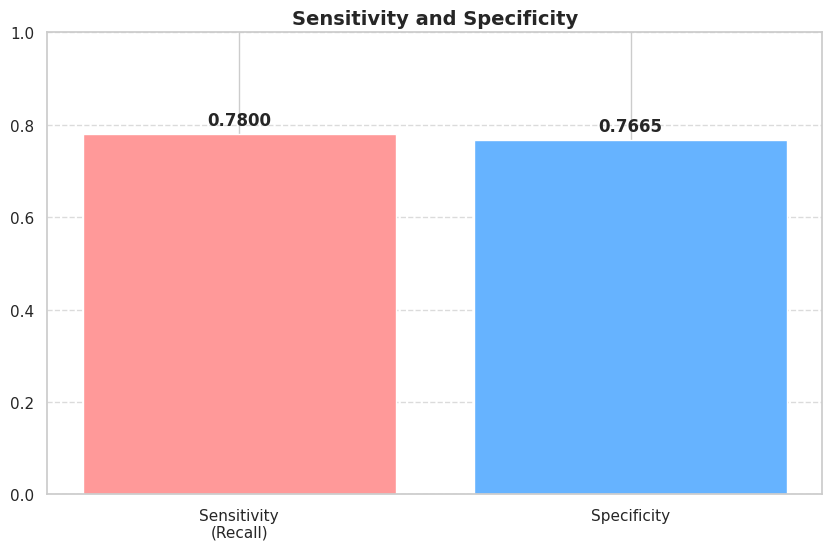

In [12]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
import os

sns.set_theme(style="whitegrid")

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'cleaned_dataset.csv')
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'bayesian_model.pkl')
REPORT_DIR = os.path.join(BASE_DIR, 'stroke-prediction-project', 'reports')
os.makedirs(REPORT_DIR, exist_ok=True)

def print_header(text):
    print("\n" + "=" * 60)
    print(text.center(60))
    print("=" * 60)

df = pd.read_csv(DATA_PATH)
X = df.drop(columns=['stroke'])
y = df['stroke']


# Applying the train-test split with 20% of the overall dataset as the test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Loading the trained model:
gnb_model = joblib.load(MODEL_PATH)

# Storing the predictions:
y_pred = gnb_model.predict(X_test)
y_pred_proba = gnb_model.predict_proba(X_test)[:, 1]

print_header("GAUSSIAN NAIVE BAYES MODEL PERFORMANCE")

# Accuracy and Classification Report:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nDetailed Classification Report:")
class_report = classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"])
print(class_report)

# Calculating the sensitivity (recall) and specificity:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)

# Printing the Evaluation Summary:
print("\nEvaluation Summary:")
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

plt.figure(figsize=(18, 5))

# 1. Confusion Matrix (Normalized):
plt.subplot(131)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. ROC Curve:
plt.subplot(132)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve:
plt.subplot(133)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.8, where='post', label=f'AP = {avg_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower left")

plt.tight_layout()
report_path = os.path.join(REPORT_DIR, 'gnb_performance_overview.png')
plt.savefig(report_path, dpi=300)

print(f"\nPerformance visualization saved to:\n   {report_path}")

plt.figure(figsize=(10, 6))
metrics = ['Sensitivity\n(Recall)', 'Specificity']
values = [sensitivity, specificity]
colors = ['#ff9999', '#66b3ff']

plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.0)
plt.title('Sensitivity and Specificity', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

sens_spec_path = os.path.join(REPORT_DIR, 'gnb_sensitivity_specificity.png')
plt.savefig(sens_spec_path, dpi=300)

print(f"\nSensitivity and Specificity visualization saved to:\n   {sens_spec_path}")

INFO: Best Parameters: {'feature_selection__k': 8, 'gnb__var_smoothing': 1e-08}
INFO: Best f1 Score: 0.2301

**Decision Tree Model**


              DECISION TREE MODEL PERFORMANCE               

Model Accuracy: 0.9834

Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.99      0.99      0.99       972
      Stroke       0.84      0.82      0.83        50

    accuracy                           0.98      1022
   macro avg       0.91      0.91      0.91      1022
weighted avg       0.98      0.98      0.98      1022


Evaluation Summary:
ROC AUC Score: 0.9059
Average Precision Score: 0.6949
Sensitivity (Recall): 0.8200
Specificity: 0.9918

Performance visualization saved to:
   /stroke-prediction-project/reports/decision_tree_performance_overview.png

Sensitivity and Specificity visualization saved to:
   /stroke-prediction-project/reports/decision_tree_sensitivity_specificity.png


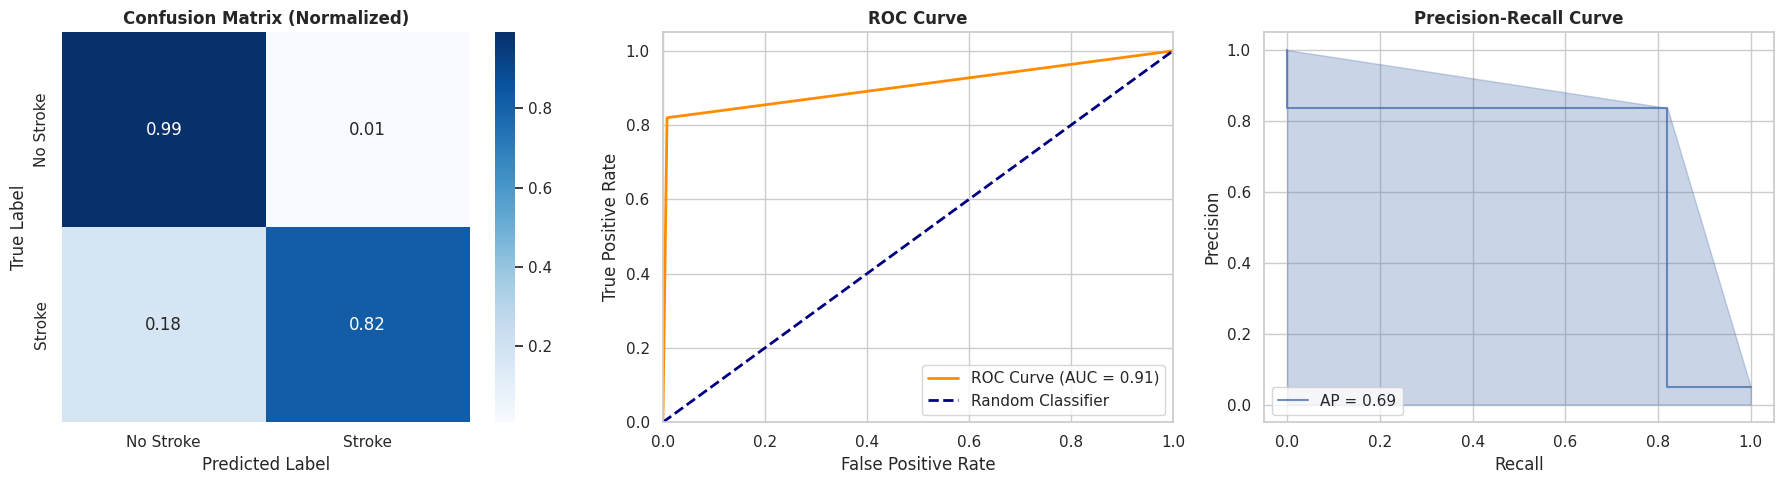

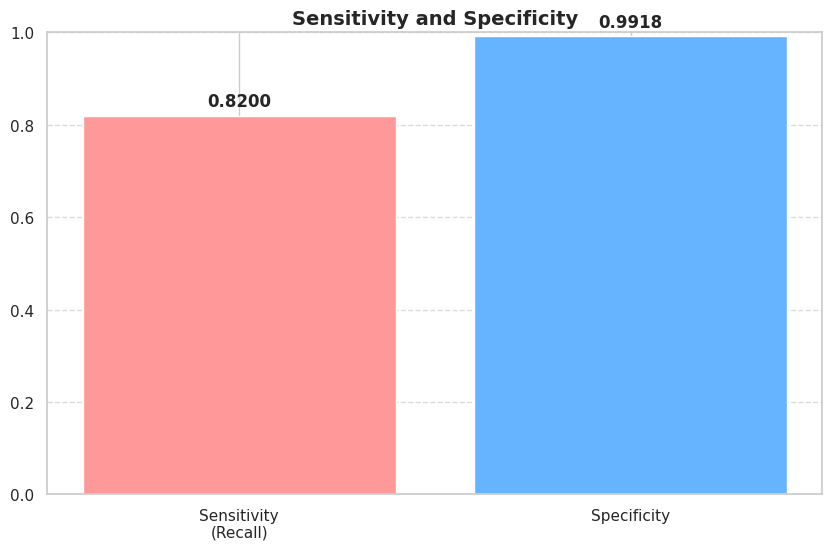

In [15]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
import os

sns.set_theme(style="whitegrid")


BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'cleaned_dataset.csv')
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'decision_tree.pkl')
REPORT_DIR = os.path.join(BASE_DIR, 'stroke-prediction-project', 'reports')
os.makedirs(REPORT_DIR, exist_ok=True)


def print_header(text):
    print("\n" + "=" * 60)
    print(text.center(60))
    print("=" * 60)

print_header("DECISION TREE MODEL PERFORMANCE")

# Load dataset:
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=['stroke'])
y = df['stroke']

X = pd.get_dummies(X)

# Applying the train-test split with 20% of the overall dataset as the test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Loading the trained model:
dt_model = joblib.load(MODEL_PATH)

# Storing the predictions:
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Accuracy & classification report:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

# Calculating the sensitivity (recall) and specificity:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)

# ROC AUC and Average Precision
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Printing the Evaluation Summary:
print("\nEvaluation Summary:")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


plt.figure(figsize=(18, 5))

# 1. Confusion Matrix (Normalized)
plt.subplot(131)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. ROC Curve
plt.subplot(132)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve
plt.subplot(133)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.step(recall, precision, color='b', alpha=0.8, where='post', label=f'AP = {avg_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower left")

plt.tight_layout()
report_path = os.path.join(REPORT_DIR, 'decision_tree_performance_overview.png')
plt.savefig(report_path, dpi=300)
print(f"\nPerformance visualization saved to:\n   {report_path}")


plt.figure(figsize=(10, 6))
metrics = ['Sensitivity\n(Recall)', 'Specificity']
values = [sensitivity, specificity]
colors = ['#ff9999', '#66b3ff']

plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.0)
plt.title('Sensitivity and Specificity', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

sens_spec_path = os.path.join(REPORT_DIR, 'decision_tree_sensitivity_specificity.png')
plt.savefig(sens_spec_path, dpi=300)
print(f"\nSensitivity and Specificity visualization saved to:\n   {sens_spec_path}")
